# Rewriting schema-aware PGs through TypedNeo4jGraph



In [1]:
from regraph import NXGraph, TypedNeo4jGraph, Rule
from regraph.attribute_sets import IntegerSet, RegexSet
from regraph import plot_rule

import json

In [2]:
%matplotlib inline

### 1. Creating and modifying a schema-aware graph object

In [3]:
# Define schema graph elements
schema_nodes = [
    ("Person", {"age": IntegerSet.universal()}),
    ("Organization", {"location": RegexSet.universal()})]
schema_edges = [
    ("Person", "Person", {"type": {"friend", "parent", "colleague"}}),
    ("Organization", "Organization"),
    ("Person", "Organization", {"type": {"works_in", "studies_in"}})
]

# Define data graph elements
data_nodes = [
    ("Alice", {"age": 15}),
    ("Bob"),
    ("Eric", {"age": 45}),
    ("Sandra", {"age": 47}),
    ("ENS Lyon", {"location": "Lyon"}),
    ("UN", {"location": "Geneva"}),
    ("INTERPOL", {"location": "Lyon"})
]
data_edges = [
    ("Alice", "Bob", {"type": "friend"}),
    ("Bob", "Alice", {"type": "friend"}),
    ("Sandra", "Eric", {"type": "friend"}),
    ("Sandra", "Bob", {"type": "parent"}),
    ("Eric", "Alice", {"type": "parent"}),
    ("Eric", "UN"),
    ("Eric", "Sandra", {"type": "colleague"})
]

# Provide typing of the data by the schema
data_typing = {
    "Alice": "Person",
    "Bob": "Person",
    "Eric": "Person",
    "Sandra": "Person",
    "ENS Lyon": "Organization",
    "UN": "Organization",
    "INTERPOL": "Organization"
}

In [4]:
# Create a schema-aware PG (clear the db in already exists)
graph = TypedNeo4jGraph(
    uri="bolt://localhost:7687",
    user="neo4j",
    password="admin",
    data_graph={"nodes": data_nodes, "edges": data_edges},
    schema_graph={"nodes": schema_nodes, "edges": schema_edges},
    typing=data_typing,
    clear=True)

In [5]:
print("Schema object: ", type(graph.get_schema()))
print("Schema nodes: ", graph.get_schema_nodes())
print("Schema edges: ", graph.get_schema_edges())

print("\nData object: ", type(graph.get_data()))
print("Data nodes: ", graph.get_data_nodes())
print("Data edges: ", graph.get_data_edges())

print("\nData typing:", json.dumps(graph.get_data_typing(), indent="   "))

Schema object:  <class 'regraph.backends.neo4j.graphs.Neo4jGraph'>
Schema nodes:  ['Person', 'Organization']
Schema edges:  [('Person', 'Organization'), ('Person', 'Person'), ('Organization', 'Organization')]

Data object:  <class 'regraph.backends.neo4j.graphs.Neo4jGraph'>
Data nodes:  ['Alice', 'Bob', 'Eric', 'Sandra', 'ENS Lyon', 'UN', 'INTERPOL']
Data edges:  [('Alice', 'Bob'), ('Bob', 'Alice'), ('Eric', 'Sandra'), ('Eric', 'UN'), ('Eric', 'Alice'), ('Sandra', 'Bob'), ('Sandra', 'Eric')]

Data typing: {
   "Sandra": "Person",
   "Eric": "Person",
   "Alice": "Person",
   "Bob": "Person",
   "UN": "Organization",
   "ENS Lyon": "Organization",
   "INTERPOL": "Organization"
}


### 2. Rewriting schema-aware graphs

ReGraph implements the rewriting technique called `sesqui-pushout rewriting` that allows to transform graphs by applying rules through their instances (matchings). Rewriting of the data or the schema may require an update to the other graph, such updates are called _propagation_ and are distinguished into two types: _backward_ and _forward_ propagation.

_Backward propagation briefly_: 
- If some graph elements (nodes/edges or attributes) are removed from the schema, then all the respective elements that are typed by them in the data **should** be removed.
- If a graph node is cloned in the schema, then for every instance of this node in the data we either: (a) specify to which clone it corresponds or (b) clone it.

_Forward propagation briefly_: 
- If some data nodes are merged and these nodes are typed by different nodes in the schema, the corresponding schema nodes **should** be merged.
- If a new graph element (node/edge or attribute) is added to the data, then we either (a) select an existing element to type the added element by the schema or (b) add a new element to the schema to type the added element.

For more details, please see [here](https://link.springer.com/chapter/10.1007/978-3-030-23611-3_9).

ReGraph allows to rewrite schema-aware PGs and their schemas using the methods `rewrite_data` and `rewrite_schema` of `TypedNeo4jGraph`. The rewriting can be done in two modes:

1. _Strict rewriting_ rewriting that does not allow propagation.

2. _Not strict rewriting_ that allows propagation.

#### 2.1. Strict rewriting 

`TypedNeo4jGraph` implements a set of methods that perform transformations of both data and schema that do not require propagation. Conider the following examples.

In [6]:
graph.add_schema_node("Country", {"location": RegexSet.universal()})
graph.add_schema_edge("Organization", "Country", {"type": {"located_in"}})

In [7]:
print("Schema nodes: ", graph.get_schema_nodes())
print("Schema edges: ", graph.get_schema_edges())

Schema nodes:  ['Person', 'Organization', 'Country']
Schema edges:  [('Person', 'Organization'), ('Person', 'Person'), ('Organization', 'Country'), ('Organization', 'Organization')]


In [8]:
graph.add_data_node("France", typing="Country", attrs={"location": "Europe"})
graph.add_data_edge("INTERPOL", "France", {"type": "located_in"})

In [9]:
print("Data nodes: ", graph.get_data_nodes())
print("Data edges: ", graph.get_data_edges())

Data nodes:  ['Alice', 'Bob', 'Eric', 'Sandra', 'ENS Lyon', 'UN', 'INTERPOL', 'France']
Data edges:  [('Alice', 'Bob'), ('Bob', 'Alice'), ('Eric', 'Sandra'), ('Eric', 'UN'), ('Eric', 'Alice'), ('Sandra', 'Bob'), ('Sandra', 'Eric'), ('INTERPOL', 'France')]


We will now create a rule that applied to the schema and that clones the node `Organization` into two nodes.

/home/eugenia/anaconda3/envs/kami/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


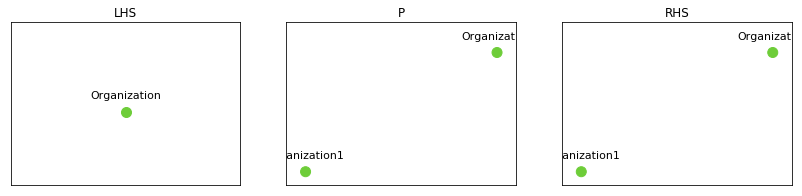

In [10]:
lhs = NXGraph()
lhs.add_nodes_from(["Organization"])

rule = Rule.from_transform(lhs)
_, rhs_clone = rule.inject_clone_node("Organization")
plot_rule(rule)

In [11]:
instance = {
    "Organization": "Organization"
}

We try to apply the created rule to the graph `T` in the strict mode.

In [12]:
try:
    rhs_instance = graph.rewrite_schema(rule, strict=True)
except Exception as e:
    print("Error message: ", e)
    print("Type: ", type(e))

Error message:  Rewriting is strict (no propagation of clones is allowed), the cloned node 'Organization' in 'type' has instances '['UN', 'ENS Lyon', 'INTERPOL']' in 'node' and their typing by P is not specified
Type:  <class 'regraph.exceptions.RewritingError'>


We have failed to rewrite the schema, because we have not specified typing for instances of `Organization` in $p$. Let us try again, but this time we will prove such typing.

In [13]:
data_typing = {
    'ENS Lyon': rhs_clone,
    'UN': "Organization",
    'INTERPOL': 'Organization'
}

In [14]:
rhs_instance = graph.rewrite_schema(rule, data_typing=data_typing, strict=True)

In [15]:
print("Instance of the RHS in G", rhs_instance)

Instance of the RHS in G {'Organization': 'Organization', 'Organization1': 'Organization1'}


Let us relabel nodes in `T`.

In [16]:
graph.relabel_schema_node(rhs_instance[rhs_clone], 'University')
graph.relabel_schema_node(rhs_instance["Organization"], "International_Organization")

In [17]:
print(json.dumps(graph.get_data_typing(), indent="   "))

{
   "Sandra": "Person",
   "Eric": "Person",
   "Alice": "Person",
   "Bob": "Person",
   "UN": "International_Organization",
   "INTERPOL": "International_Organization",
   "France": "Country",
   "ENS Lyon": "University"
}


#### 2.2. Rewriting and propagation

We now show how graph rewriting that requires propagation can be performed in such schema-aware PG. 

Let us first consider a small example of _forward propagation_. We will create a rule that performs some additions of new nodes not typed  by schema.

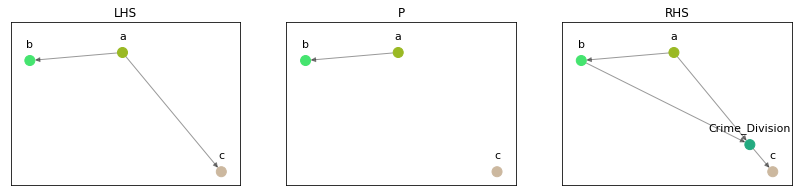

In [18]:
pattern = NXGraph()
pattern.add_nodes_from(["a", "b", "c"])
pattern.add_edges_from([
        ("a", "b", {"type": "colleague"}),
        ("a", "c")
    ])

rule = Rule.from_transform(pattern)
rule.inject_remove_edge("a", "c")
rule.inject_add_node("Crime_Division")
rule.inject_add_edge("Crime_Division", "c", {"type": "part_of"})
rule.inject_add_edge("a", "Crime_Division")
rule.inject_add_edge("b", "Crime_Division")

plot_rule(rule)

We have created a rule that clones the node `a` and reconnects the edges between `a` and `b`.

In [19]:
pattern_typing = {
    "a": "Person",
    "b":  "Person",
    "c": "International_Organization"
}
instances = graph.find_data_matching(pattern, pattern_typing=pattern_typing)
print("Instances:")
for instance in instances:
    print(instance)

Graph(3 nodes, 2 edges)
[{'a': 'Eric', 'b': 'Sandra', 'c': 'UN'}]
Instances:
{'a': 'Eric', 'b': 'Sandra', 'c': 'UN'}


We rewrite the graph `shapes` with the fixed instances (so, the node `circle` is cloned).

In [20]:
rhs_instance = graph.rewrite_data(rule, instance=instances[0])

In [21]:
print("RHS instance: ", rhs_instance)

RHS instance:  {'a': 'Eric', 'b': 'Sandra', 'c': 'UN', 'Crime_Division': 'Crime_Division'}


To type the new node 'Crime_Division', we have created a new node in the schema.

In [22]:
schema_node = graph.get_node_type(rhs_instance["Crime_Division"])
graph.relabel_schema_node(schema_node, "Division")

In [23]:
print("Schema nodes: ", graph.get_schema_nodes())
print("Schema edges: ", graph.get_schema_edges())

Schema nodes:  ['Division', 'Person', 'International_Organization', 'Country', 'University']
Schema edges:  [('Division', 'International_Organization'), ('Person', 'Division'), ('Person', 'University'), ('Person', 'International_Organization'), ('Person', 'Person'), ('International_Organization', 'University'), ('International_Organization', 'Country'), ('International_Organization', 'International_Organization'), ('University', 'University'), ('University', 'International_Organization'), ('University', 'Country')]


Now, let us consider an example of _backward propagation_. We will clone the node `Person` in the schema into a `Child` and `Adult`. We will determine which instances of `Person` are typed by `Child` or `Adult` by looking a the age attribute.

In [24]:
pattern = NXGraph()
pattern.add_nodes_from(["Person"])
pattern.add_edges_from([("Person", "Person", {"type": {"friend", "parent", "colleague"}})])

interface =  NXGraph()
interface.add_nodes_from(["Adult", "Child"])
interface.add_edges_from([
    ("Adult", "Adult", {"type": {"friend", "parent", "colleague"}}),
    ("Child", "Child", {"type": {"friend"}}),
    ("Adult", "Child", {"type": {"friend", "parent"}}),
    ("Child", "Adult", {"type": {"friend"}}),
])

rule = Rule(p=interface, lhs=pattern, p_lhs={"Adult": "Person", "Child": "Person"})

Let us determine which instances of `Person` are typed by `Child` or `Adult` as follows.

In [25]:
data_typing = {}

persons = graph.get_instances("Person")
for p in persons:
    p_attrs = graph.get_data_node(p)
    if "age" in p_attrs:
        age = list(p_attrs["age"])[0]
        if age > 18:
            data_typing[p] = "Adult"
        else:
            data_typing[p] = "Child"
            
print("Data typing: ", data_typing)

Data typing:  {'Sandra': 'Adult', 'Eric': 'Adult', 'Alice': 'Child'}


In [26]:
rhs_instance = graph.rewrite_schema(rule, data_typing=data_typing)

In [27]:
print(rhs_instance)

{'Adult': 'Person1', 'Child': 'Person'}


In [28]:
graph.relabel_schema_node(rhs_instance["Adult"], "Adult")
graph.relabel_schema_node(rhs_instance["Child"], "Child")

In [29]:
print("Schema nodes: ", graph.get_schema_nodes())
print("Schema edges: ")
for s, t in graph.get_schema_edges():
    print("\t", s, "->", t)

Schema nodes:  ['Division', 'Adult', 'Child', 'International_Organization', 'Country', 'University']
Schema edges: 
	 Division -> International_Organization
	 Adult -> Child
	 Adult -> Division
	 Adult -> Adult
	 Adult -> University
	 Adult -> International_Organization
	 Child -> Adult
	 Child -> Division
	 Child -> University
	 Child -> International_Organization
	 Child -> Child
	 International_Organization -> University
	 International_Organization -> Country
	 International_Organization -> International_Organization
	 University -> University
	 University -> International_Organization
	 University -> Country


In [30]:
print("Data nodes: ", graph.get_data_nodes())
print("Data edges: ")
for s, t, attrs in graph.get_data_edges(data=True):
    print("\t", s, "->", t, attrs)

Data nodes:  ['Crime_Division', 'Bob1', 'Alice', 'Bob', 'Eric', 'Sandra', 'ENS Lyon', 'UN', 'INTERPOL', 'France']
Data edges: 
	 Crime_Division -> UN {'type': {'part_of'}}
	 Bob1 -> Alice {'type': {'friend'}}
	 Alice -> Bob1 {'type': {'friend'}}
	 Alice -> Bob {'type': {'friend'}}
	 Bob -> Alice {'type': {'friend'}}
	 Eric -> Crime_Division {}
	 Eric -> Sandra {'type': {'colleague'}}
	 Eric -> Alice {'type': {'parent'}}
	 Sandra -> Bob1 {'type': {'parent'}}
	 Sandra -> Crime_Division {}
	 Sandra -> Bob {'type': {'parent'}}
	 Sandra -> Eric {'type': {'friend'}}
	 INTERPOL -> France {'type': {'located_in'}}


Observe that we have cloned the node `Bob` into two nodes `Bob` and `Bob1`, one being an instance of `Adult` and another of `Child`.

In [31]:
print(json.dumps(graph.get_data_typing(), indent="  "))

{
  "Crime_Division": "Division",
  "Sandra": "Adult",
  "Eric": "Adult",
  "Bob": "Adult",
  "Alice": "Child",
  "Bob1": "Child",
  "UN": "International_Organization",
  "INTERPOL": "International_Organization",
  "France": "Country",
  "ENS Lyon": "University"
}


### 3. Creating and modifying a hierarchy object

Because NetworkX graphs are in-memory objects, they are destroyed as soon as the Python application is no longer running. ReGraph provides some utils for serialization of `NXHierarchy` objects and implements the following methods for loading and exporting your hierarchy in JSON-format:

- `NXHierarchy.to_json` creates a json representations of the hierarchy;

- `NXHierarchy.from_json` loads an hierarchy from json representation (returns new `Hierarchy` object); 
- `NXHierarchy.export` exports the hierarchy to a file (json format);
- `NXHierarchy.load` loads an hierarchy from a .json file (returns new object as well).

In [32]:
graph_json = graph.to_json()

In [33]:
import json
print(json.dumps(graph_json, indent="  "))

{
  "graphs": [
    {
      "id": "type",
      "graph": {
        "edges": [
          {
            "from": "Division",
            "to": "International_Organization",
            "attrs": {
              "type": {
                "type": "FiniteSet",
                "data": [
                  "part_of"
                ]
              }
            }
          },
          {
            "from": "Adult",
            "to": "Child",
            "attrs": {
              "type": {
                "type": "FiniteSet",
                "data": [
                  "parent",
                  "friend"
                ]
              }
            }
          },
          {
            "from": "Adult",
            "to": "Division",
            "attrs": {}
          },
          {
            "from": "Adult",
            "to": "Adult",
            "attrs": {
              "type": {
                "type": "FiniteSet",
                "data": [
                  "parent",
                  "coll

In [34]:
# Clear the DB for the previous hierarchy
graph._clear()

# Load json-data back to the DB
graph = TypedNeo4jGraph.from_json(
    uri="bolt://localhost:7687", user="neo4j", password="admin", json_data=graph_json)